In [1]:
# Importing all needed module
from datetime import date, timedelta
import csv
import json
import time

import requests
import matplotlib.pyplot as plt

In [2]:
# Configuration
# The currency that we want to analyze
WANTED_KURS = ['MYR', 'JPY', 'CNY', 'USD']

# The day range of the data that we want to scrape
# Starting for today until past x days
DAY_RANGE = 14

# Folder where the folder will be saved
# Don't use / at the end of the folder name
# Default is result.csv in this folder
SAVEFILE = None

if not SAVEFILE:
    SAVEFILE = "result.csv"
    
# Parsing delay
PARSING_DELAY = 2

# Get Data From API

In [3]:
TARGET_URL = ("https://api.exchangeratesapi.io/__date__?base=IDR"
              "&symbols={}".format(','.join(WANTED_KURS))
              )

data_list = []

In [4]:
def response_parser(json_data):
    """
    Change a data from JSON into list.

    Structure of the list:
    [date, USD, GBP, EUR, CNY, JPY]
    """

    try:
        return [json_data.get("date")] \
               + [round(1/json_data.get("rates").get(n), 3) if n else 0 for n in WANTED_KURS ]
    except:
        print(json_data)

In [5]:
today = date.today()

for day in (today - timedelta(days=n) for n in range(15)):
    if day.weekday() in [5,6]:
        continue

    response = requests.get(TARGET_URL.replace("__date__", str(day)))
    data_list.append(response_parser(response.json()))
    print(f"Parsed {str(day)}")

    time.sleep(PARSING_DELAY)

Parsed 2019-07-26
Parsed 2019-07-25
Parsed 2019-07-24
Parsed 2019-07-23
Parsed 2019-07-22
Parsed 2019-07-19
Parsed 2019-07-18
Parsed 2019-07-17
Parsed 2019-07-16
Parsed 2019-07-15


# Write Data to CSV File

In [6]:
with open(SAVEFILE, "w") as data_file:
    data_writer = csv.writer(data_file,
                             delimiter=',',
                             quotechar='"',
                             quoting=csv.QUOTE_MINIMAL)

    data_writer.writerow(['Date'] + [i for i in WANTED_KURS])

    for data in data_list:
        data_writer.writerow(data)

# Read Data from CSV File

In [7]:
# Variable
plot_data = {}
key_names = []

In [8]:
with open(SAVEFILE) as file:
    csv_reader = csv.reader(file, delimiter=',')
    line_count = 0

    for row in csv_reader:
        if line_count==0:
            for key in row:
                plot_data[key] = []
            key_names = list(plot_data.keys())
            line_count += 1
        else:
            for number, value in enumerate(row):
                if number!=0:
                    value = float(value)
                plot_data[key_names[number]].append(value)

In [9]:
def normalize_column(data):
    min_n = min(data)
    max_n = max(data)

    standardized_data = [(n - min_n) / (max_n - min_n) for n in data]
    return standardized_data

In [10]:
# Standardized data from file
for key in key_names[1:]:
    plot_data[key] = normalize_column(plot_data[key])

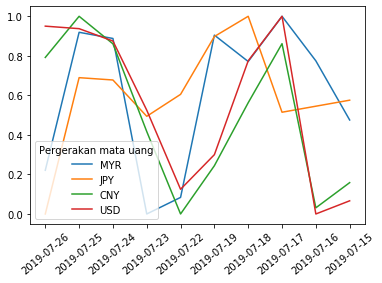

In [11]:
for number in range(1, len(key_names)):
    plt.plot(plot_data[key_names[0]],
             plot_data[key_names[number]],
             label=key_names[number])

plt.legend(title="Pergerakan mata uang")
plt.xticks(rotation=40)
plt.show()